# KSHELL Analysis 

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys
import shellmodelutilities as smutil
from matplotlib.colors import LogNorm
import os
#sys.path.append("/home/erdos/master/kshell")
from shellanalyzer import Analyzer
import shellmodelutilities2 as smutil2


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('errorbar', capsize=1.5) # Set error bar style
    
%matplotlib notebook

# Autoreload functions while testing:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Legacy code. Ignore

In [2]:
# Set bin width and range
discrete = om.Vector(path='../normalization/discrete.npy')
bin_width = (discrete.E[1] - discrete.E[0])/1e3
#bin_width = 0.20 # MeV
Emax = 20
Ex_low = 0
Ex_high = 20
Nbins = int(np.ceil(Emax/bin_width))
Emax_adjusted = bin_width*Nbins
bins = np.linspace(0,Emax_adjusted,Nbins+1)
bins_middle = (bins[0:-1]+bins[1:])/2

In [13]:
inputfile = "summary_100.txt"

transtype = "M1"

# Define spin, parity combinations to include in the analysis. The format is [2*J, pi].
#Jpi_list = [
#              [0,+1],[2,+1],[4,+1],[6,+1],[8,+1],[10,+1],[12,+1],[14,+1],[16,+1],[18,+1],[20,+1],[22,+1],[24,+1],[26,+1],[28,+1],
#              [0,-1],[2,-1],[4,-1],[6,-1],[8,-1],[10,-1],[12,-1],[14,-1],[16,-1],[18,-1],[20,-1],[22,-1],[24,-1],[26,-1],[28,-1]
#                ]
# Hack to change to odd spins (for Xe133):
#Jpi_list = [[element[0]+1, element[1]] for element in Jpi_list]
# Read energy levels
Jpi_list =  [[j, pi] for j in range(14) for pi in [-1, 1]]
levels = smutil.read_energy_levels(inputfile)
Egs = levels[0,0] # Read out the absolute ground state energy, so we can get relative energies later

# Read transition strengths
transitions = smutil2.read_transition_strengths_2(inputfile, type=transtype)


<IPython.core.display.Javascript object>


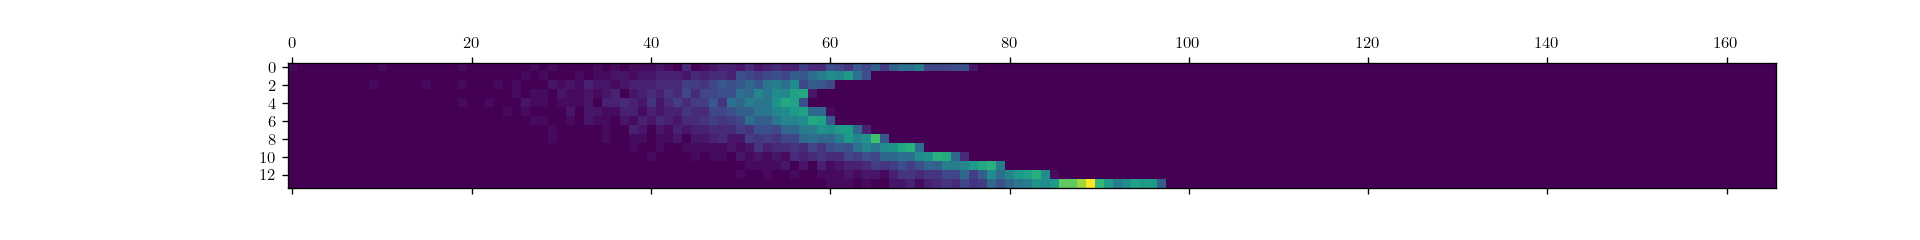

In [6]:
# Get level density matrix:
matrix, xedges, yedges = smutil.level_density_matrix(inputfile, bin_width=bin_width,
                                                     Emax=Emax, Ex_low=Ex_low, Ex_high=Ex_high)
plt.matshow(matrix)

<IPython.core.display.Javascript object>


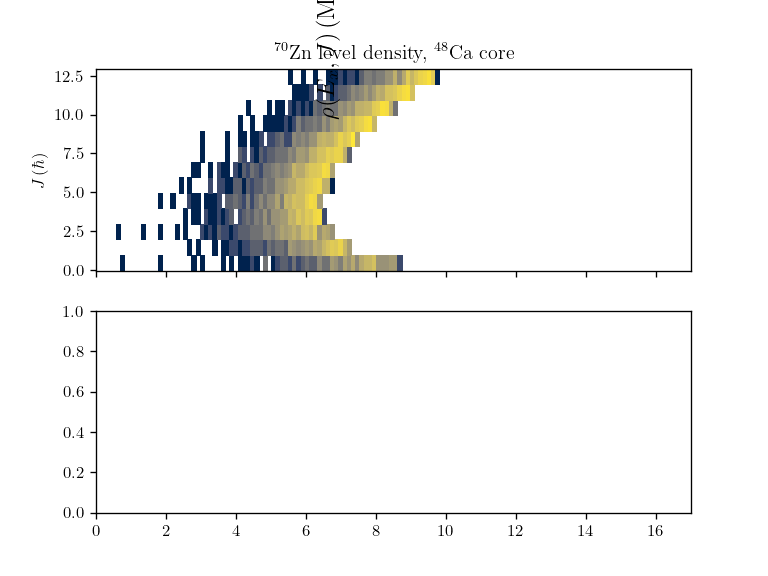

ValueError: x and y must have same first dimension, but have shapes (167,) and (166,)

In [7]:
# And plot the level density matrix:

f, (ax2d, ax1d) = plt.subplots(2,1, sharex=True)

# Plot 2D matrix:
cbar = ax2d.pcolormesh(yedges[:-1]-1/2, xedges[:-1]-bin_width/2, matrix/bin_width, norm=LogNorm(), cmap="cividis")
ax2d.set_xlim([0,17])
ax2d.set_ylabel(r"$J \,\mathrm{(}\hbar\mathrm{)}$")
ax2d.set_title(r"$^{70}$Zn level density, $^{48}$Ca core")
ax2d.text(6.2,10,r"$\rho(E_x, J) \,\mathrm{(MeV}^{-1}\mathrm{)}$", rotation="vertical", fontsize=15)

# Project on x axis and plot 1D total level density:
#ax1d.step(yedges[:-1]-1/2, matrix.sum(axis=0)/bin_width, where="mid", color="black")
ax1d.step(bins[:-1], matrix.sum(axis=0)/bin_width, where="mid", color="black")
ax1d.set_yscale("log")
ax1d.set_ylabel(r"$\rho(E_x) \,\mathrm{(MeV}^{-1}\mathrm{)}$")
ax1d.set_xlabel(r"$E_x \,\mathrm{(MeV)}$")

# Add cbar axis
f.subplots_adjust(left=0.11, right=0.85, hspace=0.1)
cbax = f.add_axes([0.86, 0.52, 0.02, 0.36])
f.colorbar(cbar, cax=cbax)

f.set_size_inches(6.7, 5)
f.savefig("level_density.pdf")

# Save to file
nld_tot = matrix.sum(axis=0)/bin_width
Emid_nld = bins_middle
np.savetxt("Zn_nld.txt", np.stack((Emid_nld, nld_tot)).T, header="Ex (MeV)    NLD (MeV^-1)")

matrix_both.shape = (28, 166)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 -0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5]


<IPython.core.display.Javascript object>


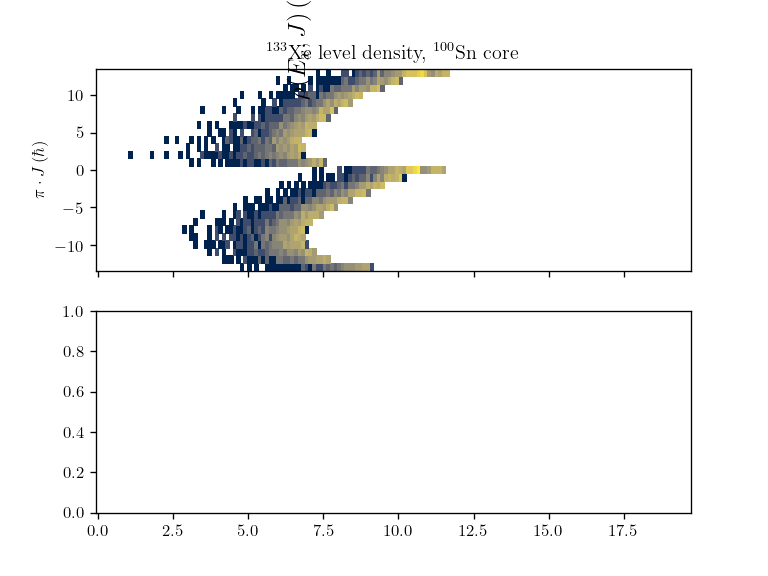

ValueError: x and y must have same first dimension, but have shapes (167,) and (166,)

In [90]:
# Get level density matrix:
matrix_plus, matrix_minus, xedges, yedges = smutil.level_density_matrix_parity_decomposed(inputfile, bin_width=bin_width,
                                                     Emax=Emax, Ex_low=Ex_low, Ex_high=Ex_high)


matrix_both = np.concatenate((matrix_minus, matrix_plus), axis=0)
print("matrix_both.shape =", matrix_both.shape)

print(xedges)
print(np.concatenate((xedges[:-1], xedges[:-1]))-1/2)

f, (ax2d, ax1d) = plt.subplots(2,1, sharex=True)

# Plot 2D matrix:
cbar = ax2d.pcolormesh((yedges[:-1])-bin_width/2, np.concatenate((-xedges[::-1], xedges[:-1]))+1/2, matrix_both/bin_width, norm=LogNorm(), cmap="cividis")
#ax2d.set_xlim([0,17])
ax2d.set_ylabel(r"$\pi \cdot J \,\mathrm{(}\hbar\mathrm{)}$")
ax2d.set_title(r"$^{133}$Xe level density, $^{100}$Sn core")
ax2d.text(6.2,10,r"$\rho(E_x, J) \,\mathrm{(MeV}^{-1}\mathrm{)}$", rotation="vertical", fontsize=15)

# Project on x axis and plot 1D total level density:
#ax1d.step(yedges[:-1]-1/2, matrix.sum(axis=0)/bin_width, where="mid", color="black")
ax1d.step(bins[:-1], matrix.sum(axis=0)/bin_width, where="mid", color="black")
#ax1d.set_xlim([0,5.5])
ax1d.set_yscale("log")
ax1d.set_ylabel(r"$\rho(E_x) \,\mathrm{(MeV}^{-1}\mathrm{)}$")
ax1d.set_xlabel(r"$E_x \,\mathrm{(MeV)}$")

# Add cbar axis
f.subplots_adjust(left=0.11, right=0.85, hspace=0.1)
cbax = f.add_axes([0.86, 0.52, 0.02, 0.36])
f.colorbar(cbar, cax=cbax)

f.set_size_inches(6.7, 5)
f.savefig("Xe133_level_density.pdf")

# Save to file
nld_tot = matrix.sum(axis=0)/bin_width
Emid_nld = bins_middle
np.savetxt("Zn70_100.txt", np.stack((Emid_nld, nld_tot)).T, header="Ex (MeV)    NLD (MeV^-1)")

In [14]:
# Get averaged gSF:
gSF = smutil.strength_function_average(levels, transitions,
                                         Jpi_list=Jpi_list, bin_width=0.12,
                                         Ex_min=0, Ex_max=20, type="M1")

<IPython.core.display.Javascript object>


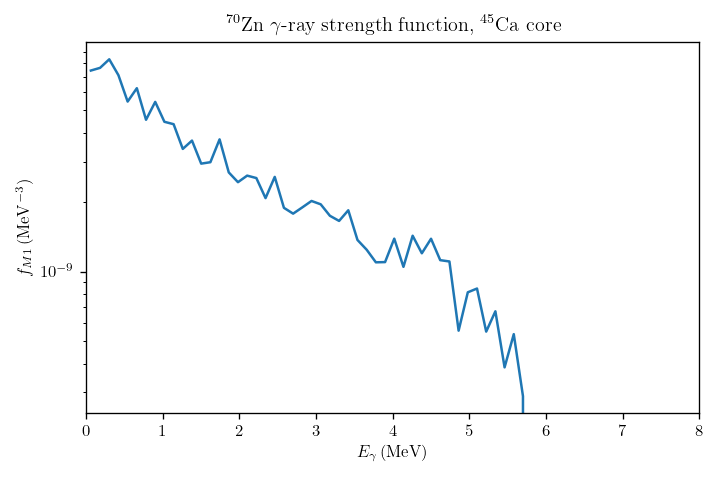

In [15]:
# Plot averaged gSF

f, ax = plt.subplots(1)

ax.plot(bins_middle, gSF)
ax.set_title(r"$^{70}$Zn $\gamma$-ray strength function, $^{45}$Ca core")
ax.set_yscale("log")
ax.set_xlim([0,8])
ax.set_xlabel(r"$E_\gamma\,\mathrm{(MeV)}$")
ax.set_ylabel(r"$f_{M1}\,\mathrm{(MeV^{-3})}$")


f.set_size_inches(6,4)

plt.tight_layout(True)
f.savefig("Zn70_100.pdf")



# Save to file
np.savetxt("Zn70_gsf_100.txt", np.stack((bins_middle, gSF)).T, header="Eg (MeV)    gSF (MeV^-3)")

<IPython.core.display.Javascript object>


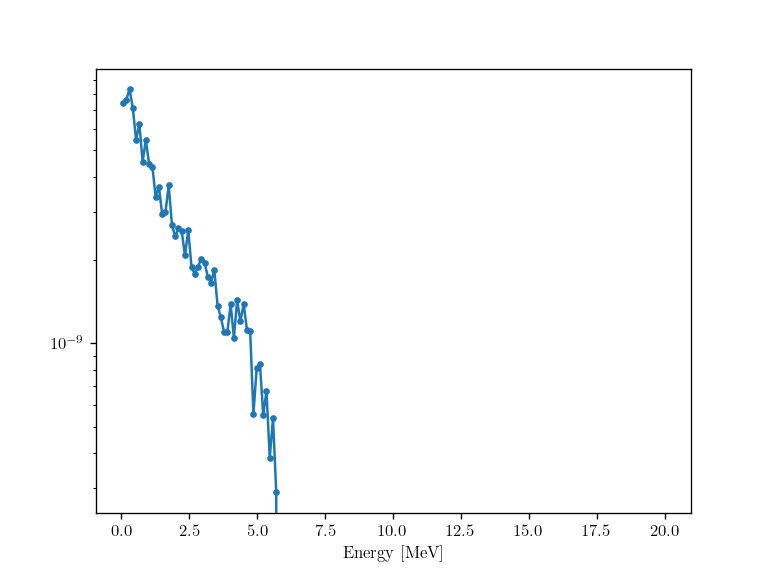

In [34]:
gsf_vec = om.Vector(E=bins_middle, values=gSF, units='MeV')
gsf_vec.plot(scale='log')
gsf_vec.save("../matrices/gsf_sm.npy")

(167, 167, 28)
9.565013500000001e-08


<IPython.core.display.Javascript object>


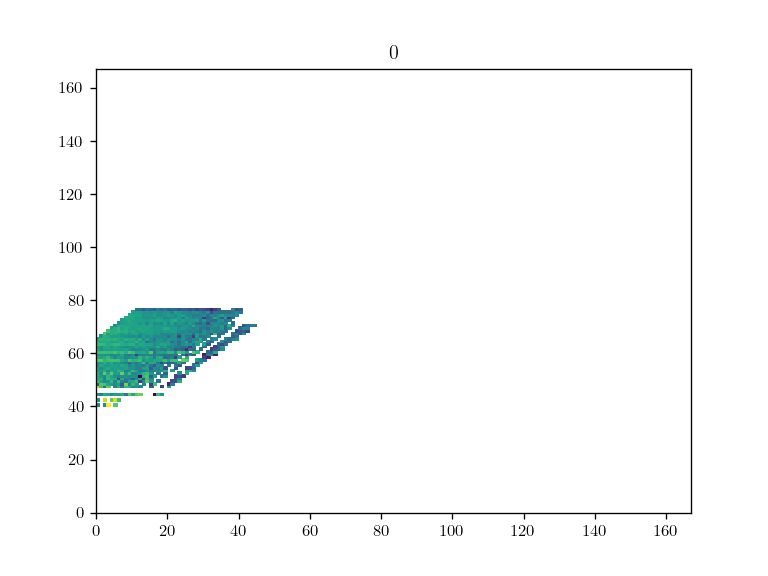

<IPython.core.display.Javascript object>


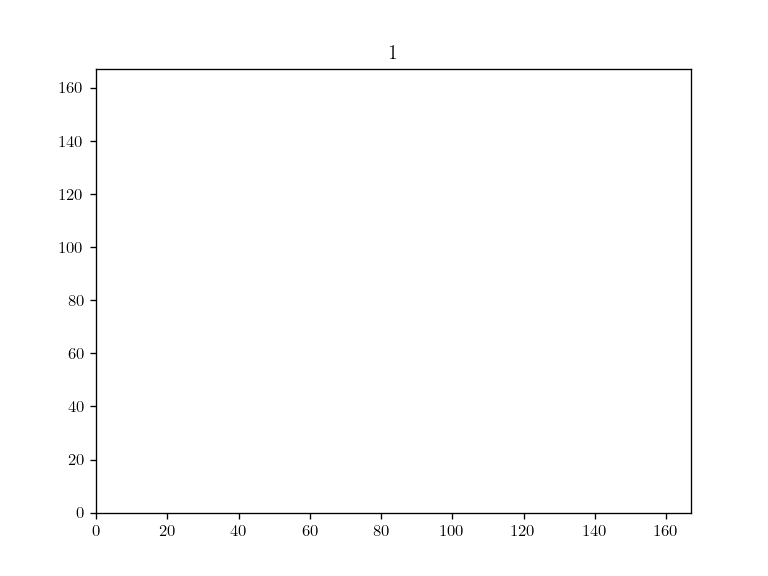

<IPython.core.display.Javascript object>


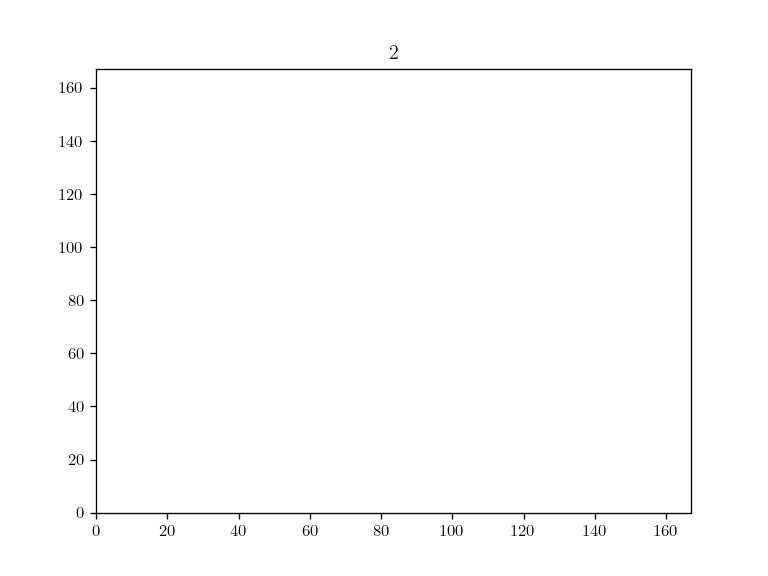

<IPython.core.display.Javascript object>


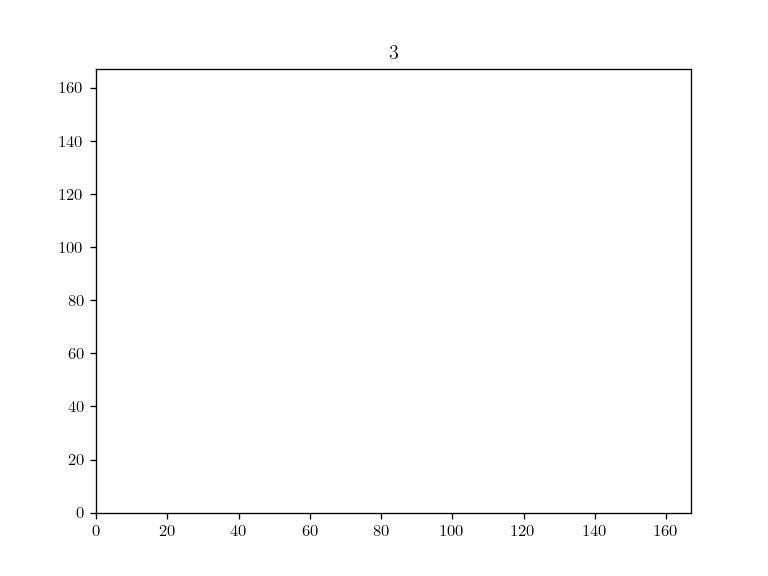

<IPython.core.display.Javascript object>


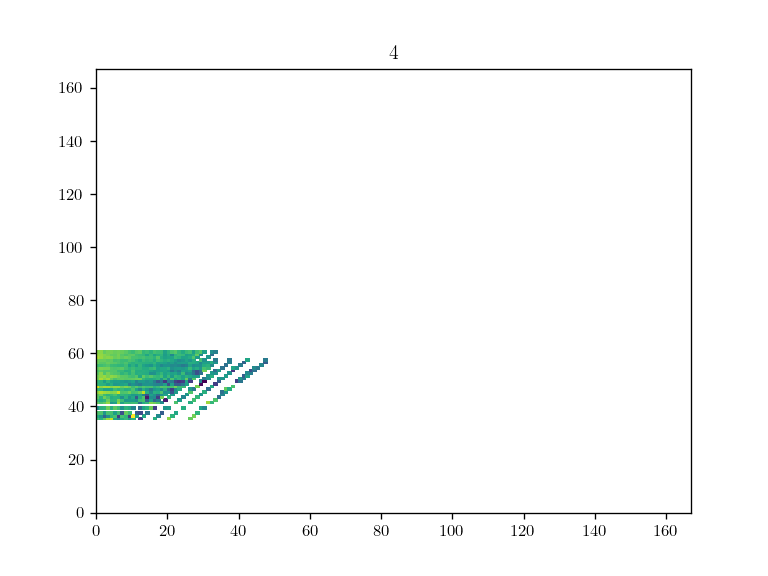

<IPython.core.display.Javascript object>


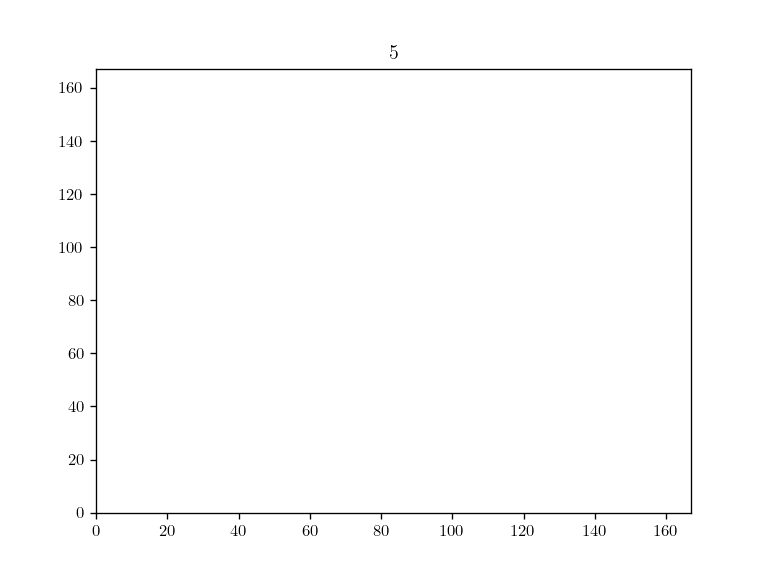

<IPython.core.display.Javascript object>


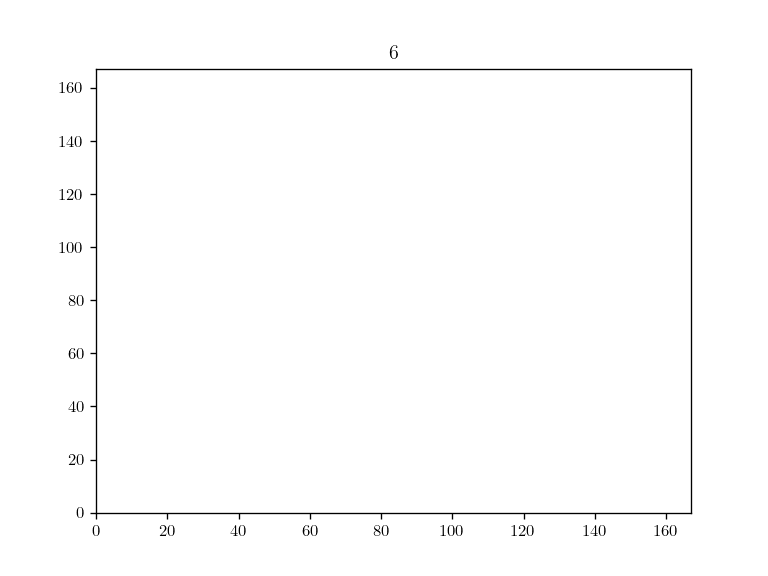

<IPython.core.display.Javascript object>


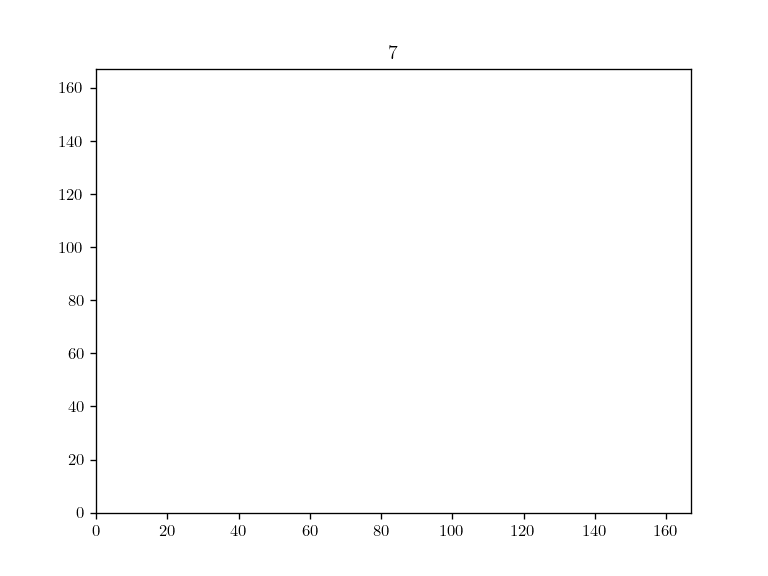

<IPython.core.display.Javascript object>


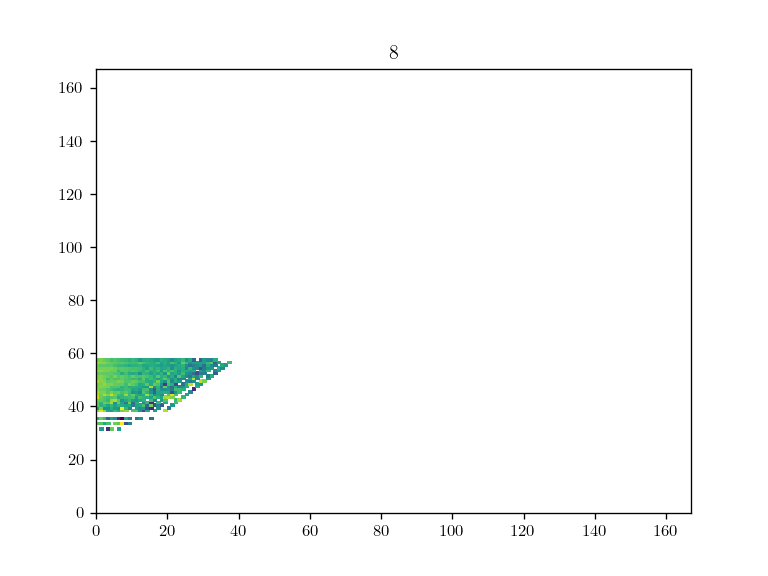

<IPython.core.display.Javascript object>


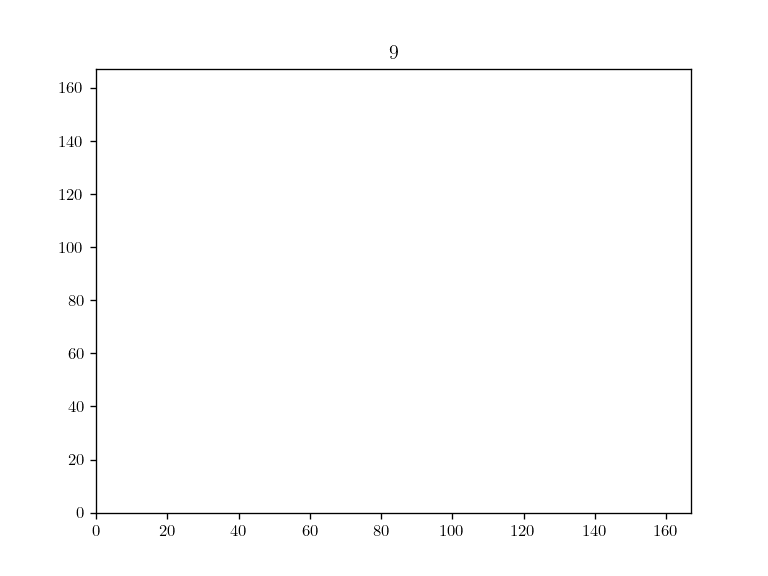

<IPython.core.display.Javascript object>


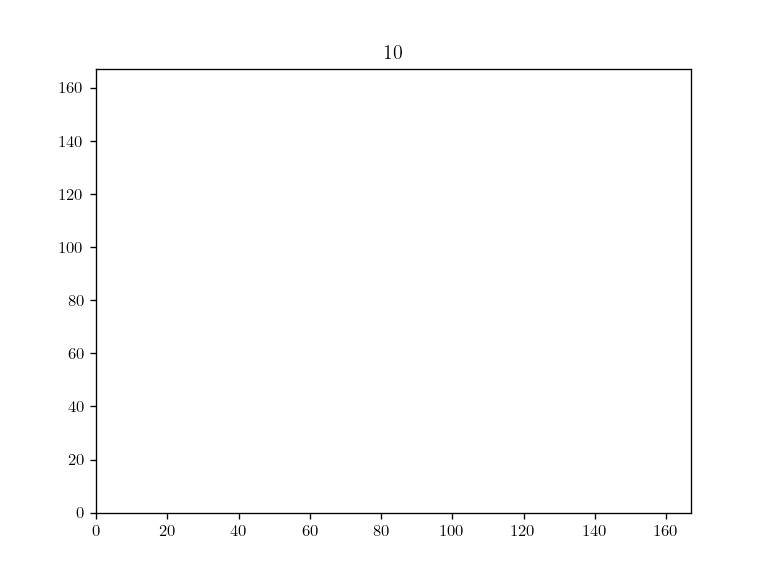

<IPython.core.display.Javascript object>


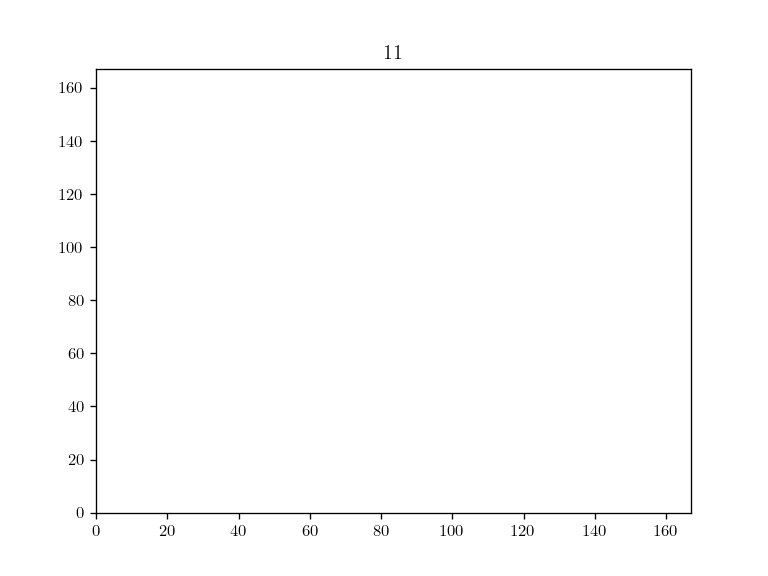

<IPython.core.display.Javascript object>


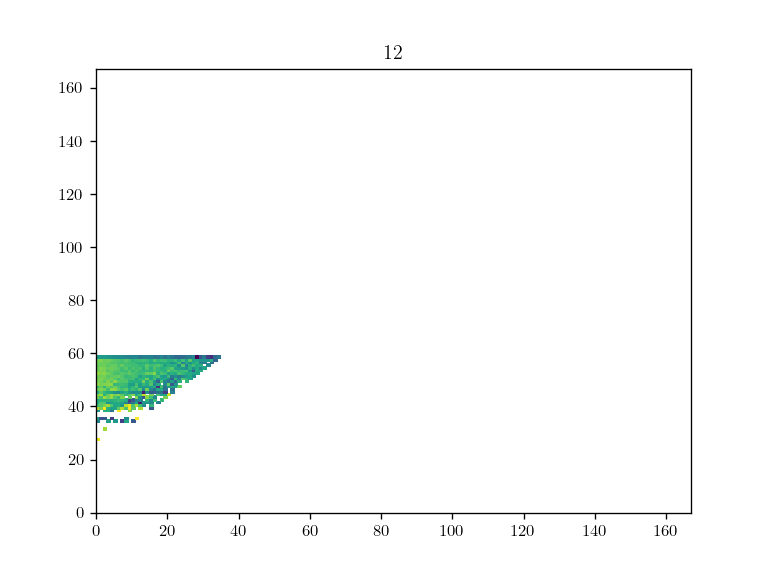

<IPython.core.display.Javascript object>


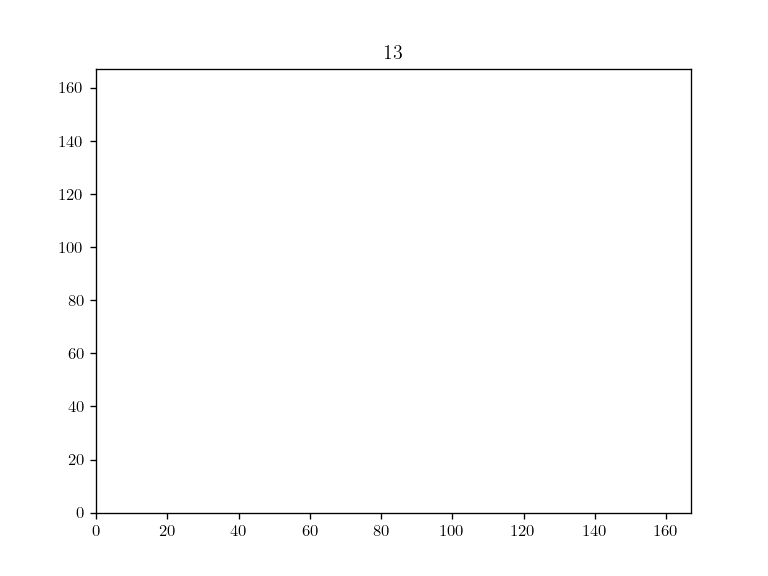

<IPython.core.display.Javascript object>


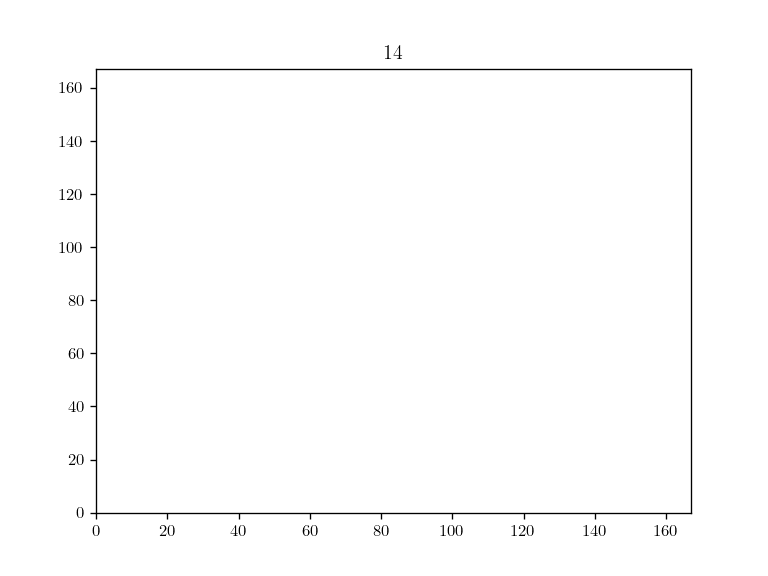

<IPython.core.display.Javascript object>


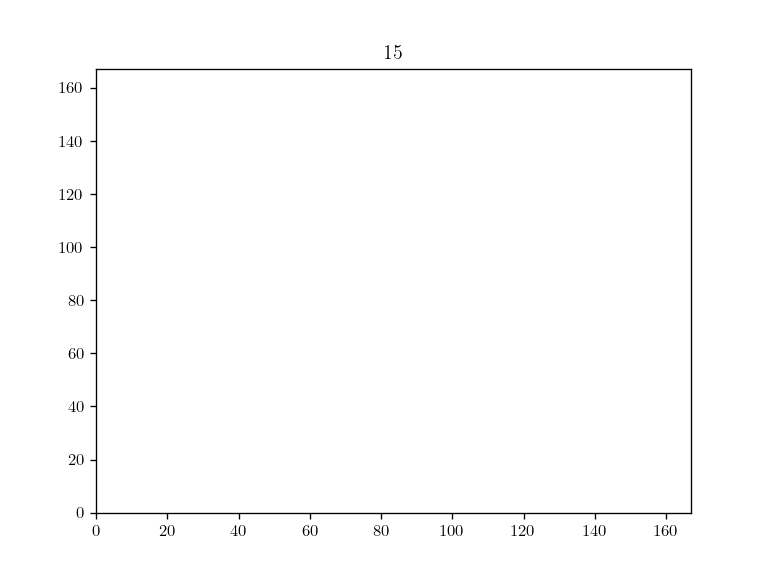

<IPython.core.display.Javascript object>


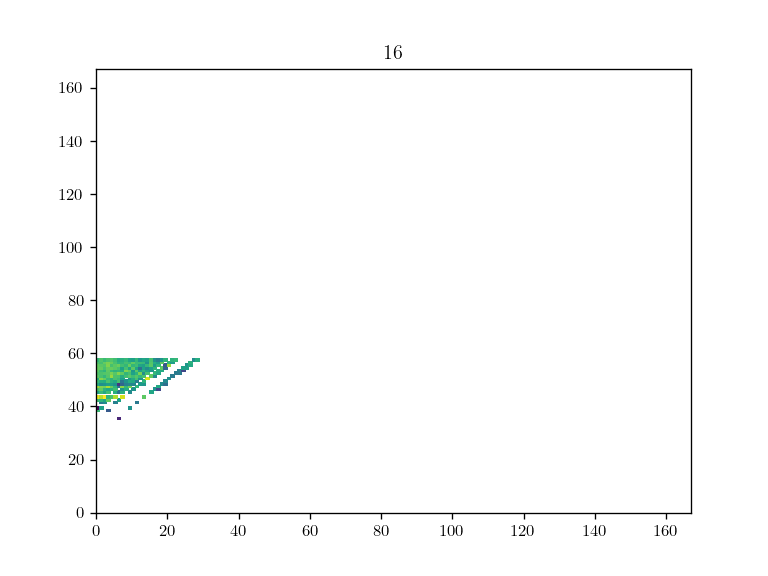

<IPython.core.display.Javascript object>


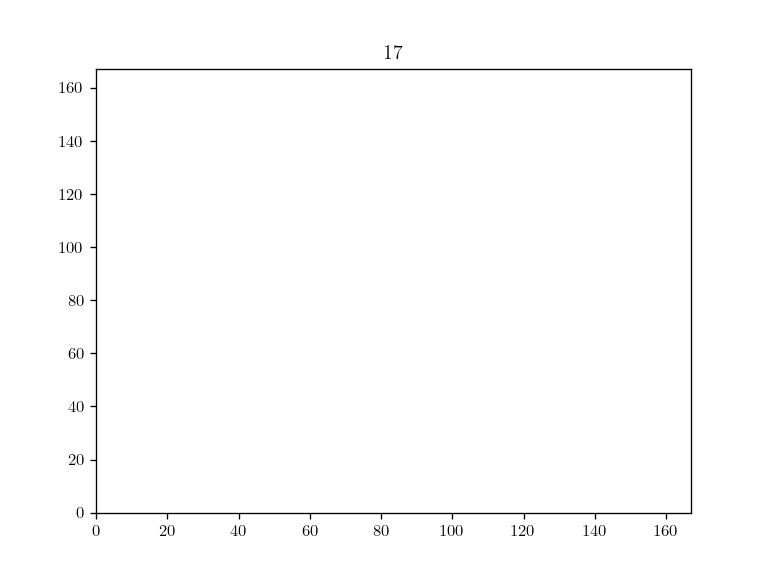

<IPython.core.display.Javascript object>


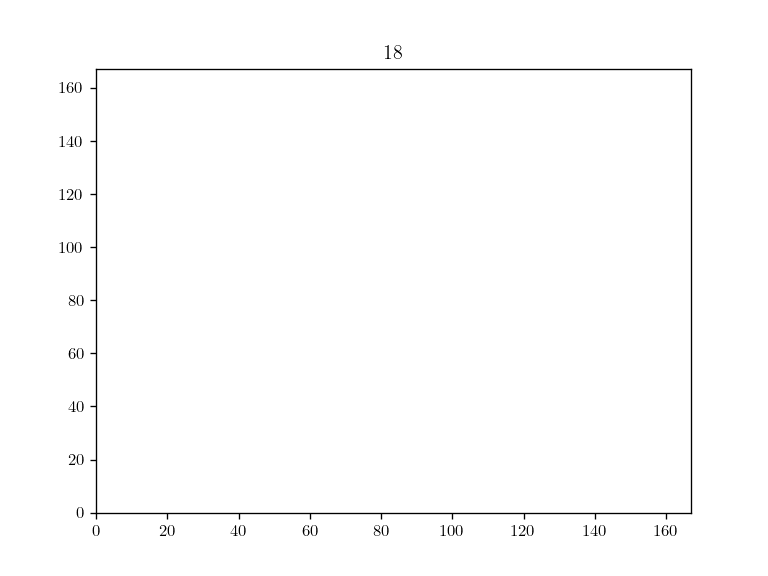

<IPython.core.display.Javascript object>


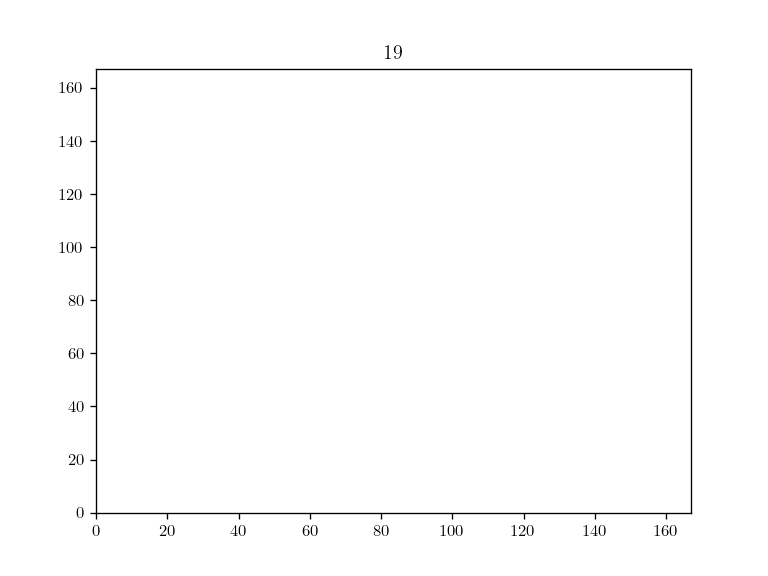

In [18]:
gSF_pixels = smutil.strength_function_pixelated(levels, transitions,
                                         Jpi_list=Jpi_list, bin_width=bin_width,
                                         Ex_min=0, Ex_max=20, type="M1")

from matplotlib.colors import LogNorm
print(gSF_pixels.shape)
print(gSF_pixels[:,:,0].max())
for i in range(20):
    plt.subplots()
    plt.pcolormesh(gSF_pixels[:,:,i], norm=LogNorm())
    plt.title(i)
    plt.show()

<IPython.core.display.Javascript object>


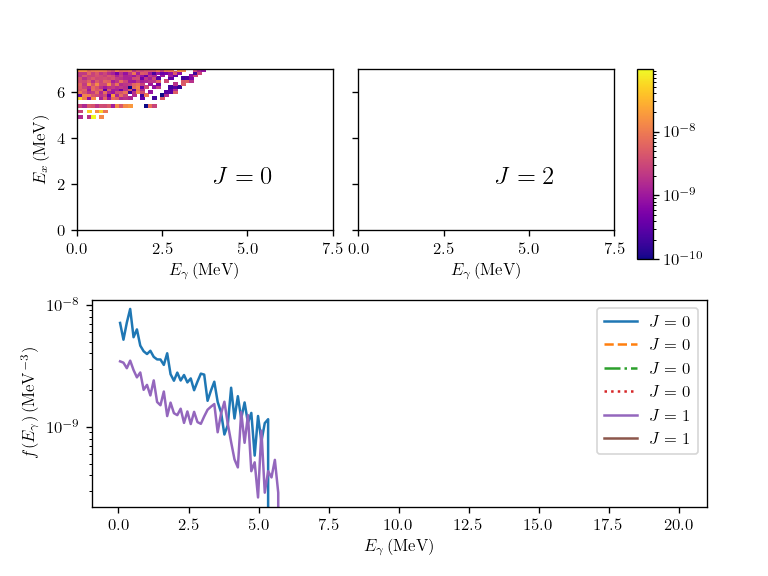

vmin = 1e-10 vmax = 9.565013500000001e-08


In [19]:
f, (ax2d1, ax2d2) = plt.subplots(1,2, sharey=True)

iJ1 = 0
iJ2 = 10


vmin = 1e-10
vmax = np.max((gSF_pixels[:,:,iJ1], gSF_pixels[:, :, iJ2]))
#vmax = 1e-8

print("vmin =", vmin, "vmax =", vmax)

cbar = ax2d1.pcolormesh(bins_middle, bins_middle,gSF_pixels[:,:,iJ1], norm=LogNorm(vmin=vmin, vmax=vmax), cmap="plasma")
ax2d1.set_ylim([0, 7])
ax2d1.set_xlim([0, 7])
ax2d1.set_xticks([0, 2.5, 5, 7.5])
ax2d1.set_ylabel(r"$E_x \, \mathrm{(MeV)}$")
ax2d1.set_xlabel(r"$E_\gamma \, \mathrm{(MeV)}$")
ax2d1.text(4, 2,  "$J={:d}$".format(int(Jpi_list[iJ1][0]/2)), fontsize=15)

ax2d2.pcolormesh(bins_middle, bins_middle,gSF_pixels[:,:,iJ2], norm=LogNorm(vmin=vmin, vmax=vmax), cmap="plasma")
ax2d2.set_ylim([0, 7])
ax2d2.set_xlim([0, 7])
ax2d2.set_xticks([0, 2.5, 5, 7.5])
ax2d2.set_xlabel(r"$E_\gamma \, \mathrm{(MeV)}$")
ax2d2.text(4, 2,  "$J={:d}$".format(int(Jpi_list[iJ2][0]/2)), fontsize=15)




# Add cbar axis
f.subplots_adjust(left=0.1, right=0.8, hspace=0.1)
cbax = f.add_axes([0.83, 0.55, 0.02, 0.33])
f.colorbar(cbar, cax=cbax)

cbax.text(5, 0.7, r"$f \, \mathrm{(MeV^{-3})}$",
          rotation=90, fontsize=15)


# Add axes below
linestyles = ["-", "--", "-.", ":", "-", "-"]
f.subplots_adjust(bottom=0.6, left=0.1, wspace=0.1, hspace=0.1)
ax1d = f.add_axes([0.12, 0.12, 0.8, 0.36])
# Plot 1D gsfs for some spins, averaged over Ex
counter = -1
for iJ in [0, 1, 2, 3, 4, 5]:
    counter += 1
    gsf_current = np.zeros(len(bins_middle))
    for i_Eg in range(len(bins_middle)):
        counter_nonzero = 0
        for i_Ex in range(len(bins_middle)):
            if gSF_pixels[i_Ex, i_Eg, iJ] > 0:
                gsf_current[i_Eg] += gSF_pixels[i_Ex, i_Eg, iJ]
                counter_nonzero += 1
        if counter_nonzero > 0:
            gsf_current[i_Eg] /= counter_nonzero
    ax1d.plot(bins_middle, gsf_current, label="$J={:d}$".format(int(Jpi_list[iJ][0]/2)),
              linestyle=linestyles[counter])


ax1d.legend()
ax1d.set_ylabel(r"$f(E_\gamma)\, \mathrm{(MeV^{-3})}$")
ax1d.set_xlabel(r"$E_\gamma \, \mathrm{(MeV)}$")
#ax1d.set_xlim([0, 5])

ax1d.set_yscale("log")

#f.set_size_inches(6.7, 5)
#f.savefig("Xe133_M1_gamma_strength_function-Brink_Axel_checks.pdf")
plt.show()

In [29]:
analyzer = Analyzer(inputfile, bin_width=bin_width, Ex_max=Emax_adjusted, Ex_min=0)

<IPython.core.display.Javascript object>


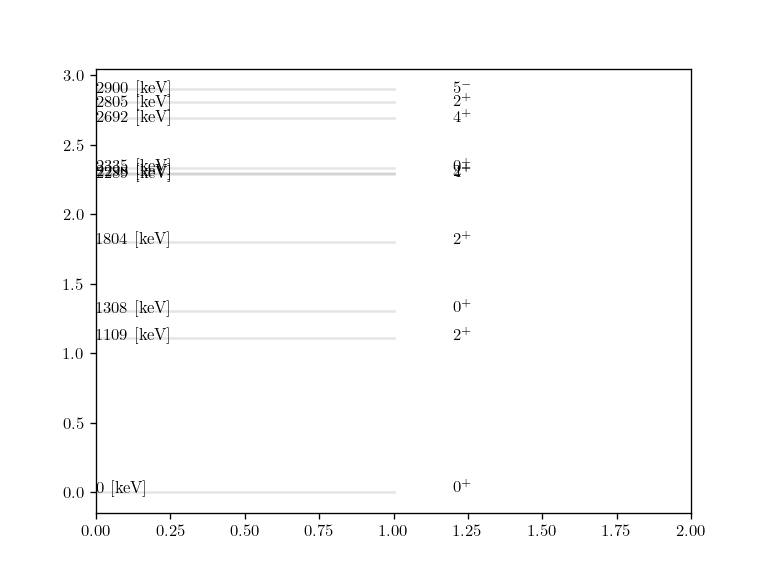

In [30]:
analyzer.plot_scheme()
plt.show()

<IPython.core.display.Javascript object>


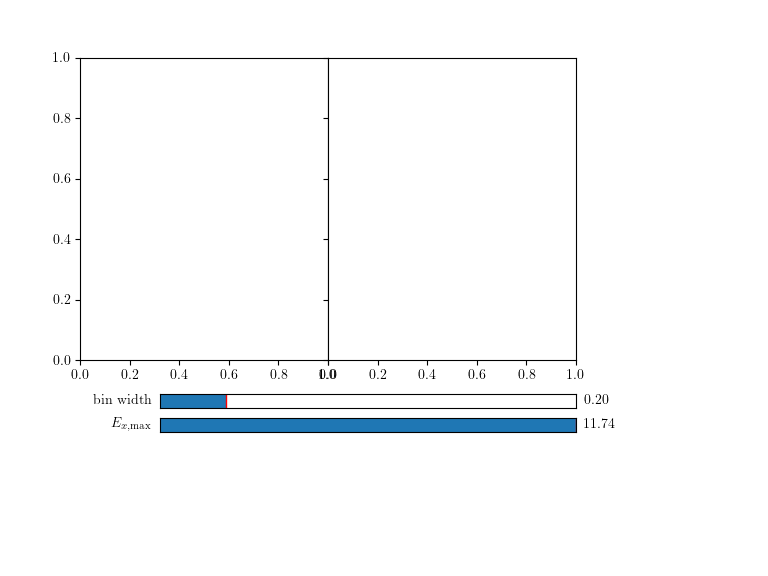

TypeError: total_level_density() got an unexpected keyword argument 'bin_width'

In [31]:
analyzer.plot_level_density()

<IPython.core.display.Javascript object>


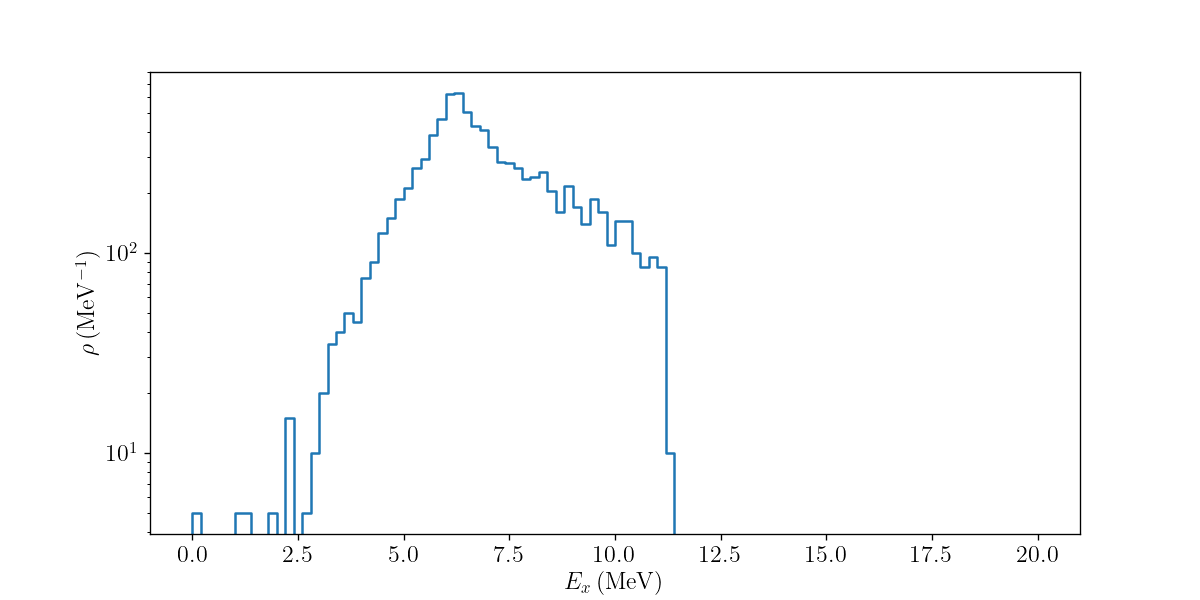

<IPython.core.display.Javascript object>


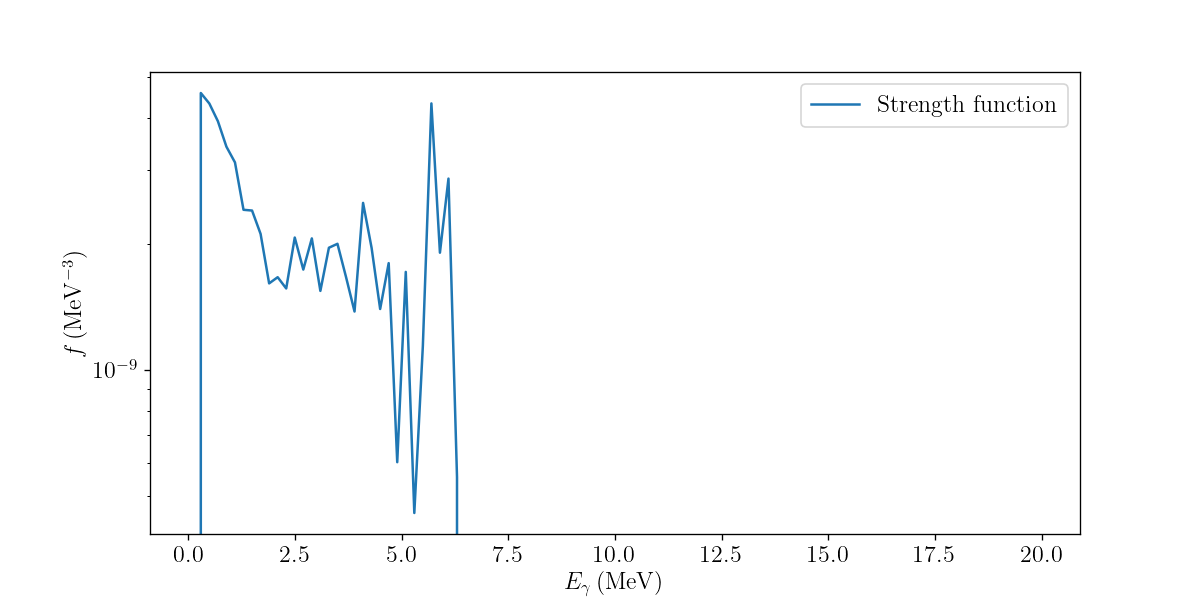

In [20]:
analyzer.plot_gamma_strength_function()

In [19]:
analyzer.transitions

,Ji,pi_i,Ei,Jf,pi_f,Ef,dE,BM1,JiPi,JfPi
0,0,-1,4.870,2,-1,4.250,0.620,0.137,"(0, -1)","(2, -1)"
1,0,-1,4.870,2,-1,4.401,0.469,0.994,"(0, -1)","(2, -1)"
2,0,-1,4.870,2,-1,4.555,0.315,0.020,"(0, -1)","(2, -1)"
3,0,-1,4.870,2,-1,4.771,0.098,0.016,"(0, -1)","(2, -1)"
4,2,-1,4.960,0,-1,4.870,0.091,0.014,"(2, -1)","(0, -1)"
...,...,...,...,...,...,...,...,...,...,...
150356,8,1,6.256,8,1,6.222,0.035,0.013,"(8, 1)","(8, 1)"
150357,8,1,6.276,8,1,6.222,0.054,0.001,"(8, 1)","(8, 1)"
150358,8,1,6.256,8,1,6.238,0.018,0.000,"(8, 1)","(8, 1)"
150359,8,1,6.276,8,1,6.238,0.038,0.021,"(8, 1)","(8, 1)"


In [37]:
nndc = om.NNDC('70Zn')

<IPython.core.display.Javascript object>


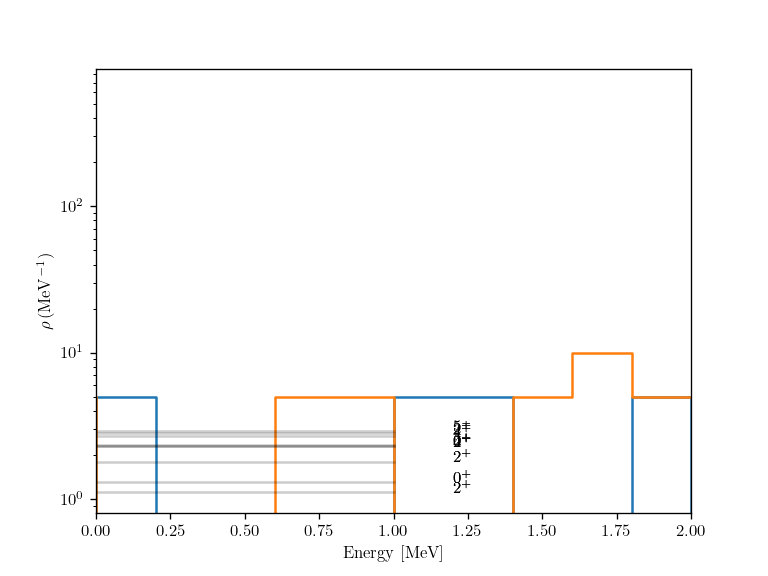

(0.0, 12.5)

In [73]:
(bins, rho), ax = analyzer.plot_total_level_density()
nndc.level_hist(bins).plot(ax=ax, kind='step', where='pre')
ax.set_yscale('log')
ax.set_xlim(0, 12.5)

In [51]:
nndc.levels()

array([   0.  ,  884.92, 1070.76, 1554.  , 1759.16, 1786.75, 1957.28,
       2140.64, 2375.  , 2538.31, 2665.  , 2693.4 , 2805.  , 2859.49,
       2895.1 , 2949.67, 2954.  , 2978.26, 3022.  , 3038.15, 3222.08,
       3235.  , 3246.71, 3328.  , 3342.  , 3419.  , 3464.  , 3476.68,
       3506.  , 3598.98, 3634.99, 3680.  , 3710.7 , 3750.  , 3755.4 ,
       3788.16, 3813.  , 3844.  , 3848.4 , 3888.  , 3904.  , 3914.  ,
       3948.  , 3999.  , 4001.46, 4016.  , 4061.4 , 4066.  , 4136.  ,
       4146.1 , 4172.  , 4264.5 , 4291.  , 4308.99, 4367.  , 4444.  ,
       4464.77, 4514.27, 4558.2 , 4588.8 , 4710.1 , 4791.7 , 4849.2 ,
       4935.9 , 5061.3 , 6116.2 ])

In [74]:
print(bins.shape, rho.shape)
rho_vec = om.Vector(E=bins[:-1], values=rho)
rho_vec.save('kshell.npy')

(102,) (101,)


In [92]:
bins, rho = analyzer.total_level_density()
vec = om.Vector(E=bins, values=rho, units='MeV')
vec.save('kshell.npy')

bin_width=0.12


<IPython.core.display.Javascript object>


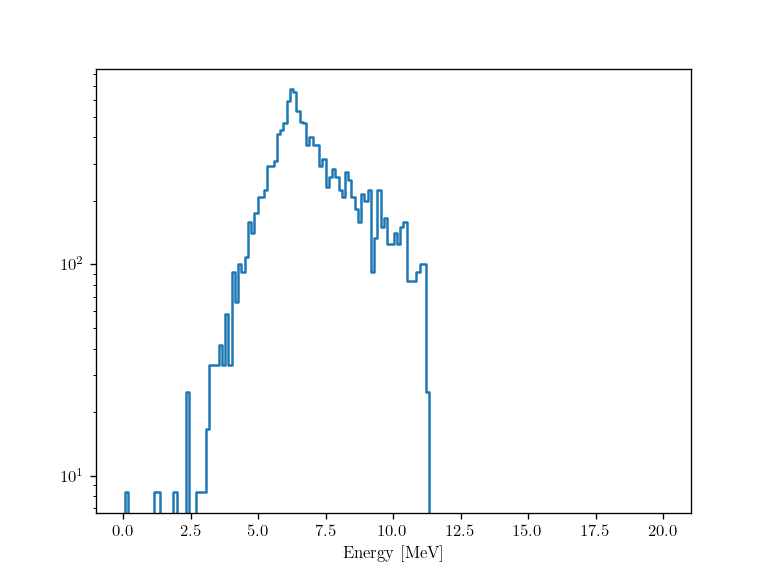

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8e4e830430>)

In [91]:
vec = om.Vector(E=bins, values=rho, units='MeV').plot(kind='step', scale='log')

# Comparisons

In [49]:
bin_width = 0.120
Ex_max = 12.5
inputfile = "summary_100.txt"
analyzer = Analyzer(inputfile, bin_width=bin_width, Ex_max=Ex_max)

Nbins=104
self.Ex_max=12.48


In [50]:
analyzer.levels

,J,Parity,E,Ex,JPi
0,0,1,-145.726,0.000,"(0, 1)"
1,2,1,-144.618,1.109,"(2, 1)"
2,0,1,-144.419,1.308,"(0, 1)"
3,2,1,-143.922,1.804,"(2, 1)"
4,4,1,-143.437,2.289,"(4, 1)"
...,...,...,...,...,...
2995,14,1,-134.021,11.705,"(14, 1)"
2996,14,1,-134.012,11.714,"(14, 1)"
2997,14,1,-134.005,11.722,"(14, 1)"
2998,14,1,-134.000,11.726,"(14, 1)"


<IPython.core.display.Javascript object>


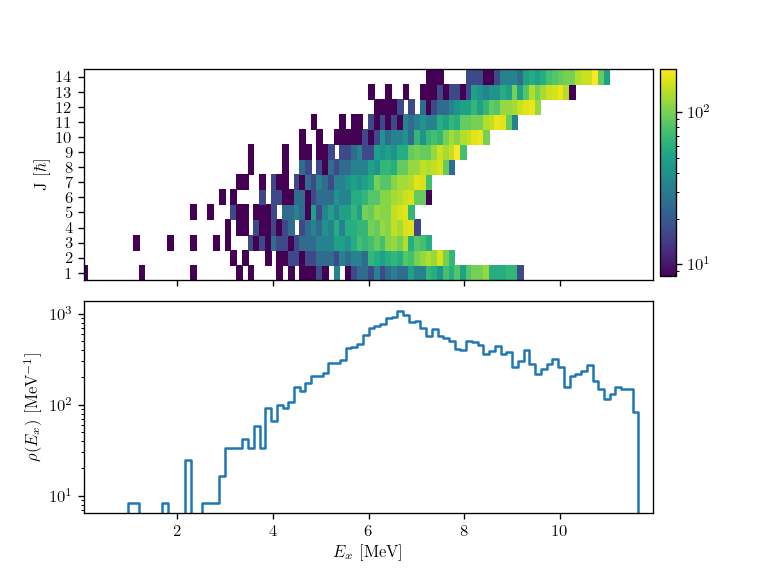

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8bf347190>,
      dtype=object)

In [94]:
fig, ax = plt.subplots(nrows=2, sharex=True)
analyzer.plot_nld(ax=ax)

In [58]:
(J, Ex), pos, neg = analyzer.partial_nld()

(15, 105)
(16,)
(106,)


<IPython.core.display.Javascript object>


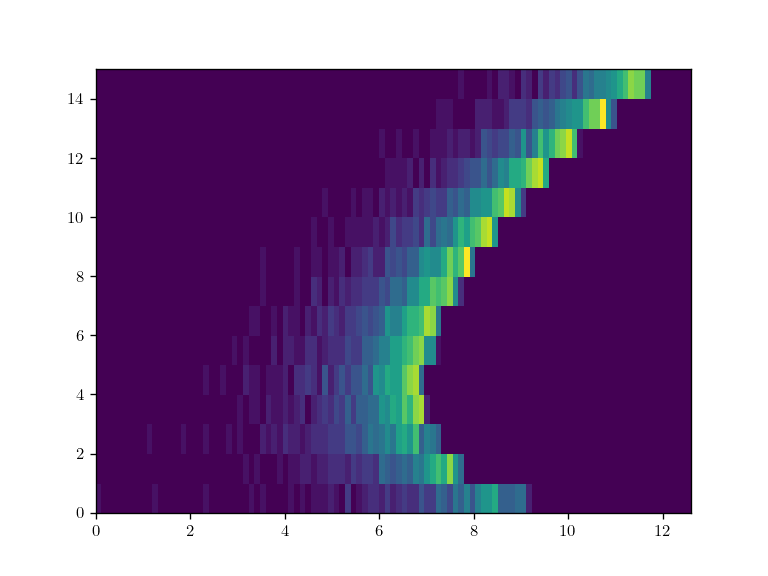

<IPython.core.display.Javascript object>


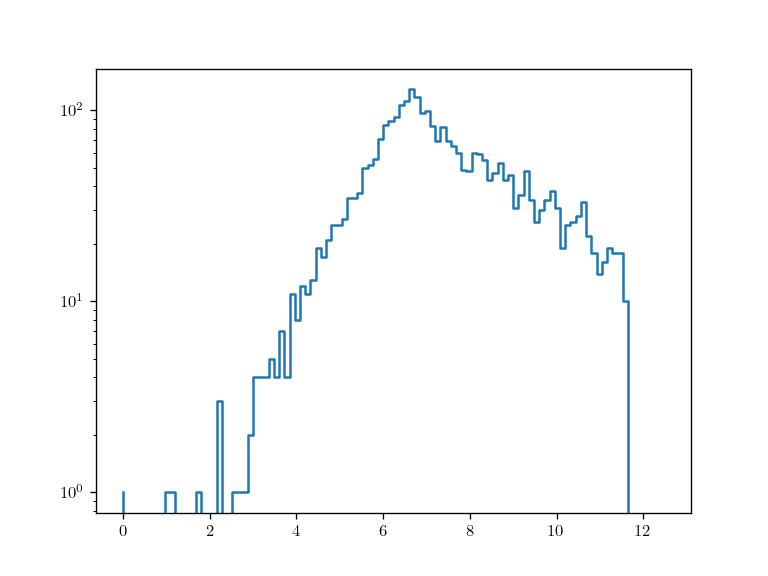

In [92]:
fig, ax = plt.subplots()
Js = analyzer.levels['J'].to_numpy()
levels = analyzer.levels['Ex'].to_numpy()

nld, yedge, xedge = np.histogram2d(Js, levels, bins=[J, Ex])
plt.pcolormesh(xedge, yedge, nld)

s = nld.sum(axis=0)
fig, ax = plt.subplots()
ax.step(Ex[:-1], s)
ax.set_yscale('log')
#plt.yscale('log')

In [57]:
E, nld = analyzer.total_nld()
print(E)
print(nld)
om.Vector(E=E[:-1], values=nld).save('../matrices/nld_sm.npy')

(15, 105)
(16,)
(106,)
[ 0.    0.12  0.24  0.36  0.48  0.6   0.72  0.84  0.96  1.08  1.2   1.32
  1.44  1.56  1.68  1.8   1.92  2.04  2.16  2.28  2.4   2.52  2.64  2.76
  2.88  3.    3.12  3.24  3.36  3.48  3.6   3.72  3.84  3.96  4.08  4.2
  4.32  4.44  4.56  4.68  4.8   4.92  5.04  5.16  5.28  5.4   5.52  5.64
  5.76  5.88  6.    6.12  6.24  6.36  6.48  6.6   6.72  6.84  6.96  7.08
  7.2   7.32  7.44  7.56  7.68  7.8   7.92  8.04  8.16  8.28  8.4   8.52
  8.64  8.76  8.88  9.    9.12  9.24  9.36  9.48  9.6   9.72  9.84  9.96
 10.08 10.2  10.32 10.44 10.56 10.68 10.8  10.92 11.04 11.16 11.28 11.4
 11.52 11.64 11.76 11.88 12.   12.12 12.24 12.36 12.48 12.6 ]
[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.           16.66666667
    0.    

In [69]:
analyzer.transition

,Ji,pi_i,Ei,Jf,pi_f,Ef,dE,BM1,JiPi,JfPi
0,0,-1,4.870,2,-1,4.250,0.620,0.137,"(0, -1)","(2, -1)"
1,0,-1,4.870,2,-1,4.401,0.469,0.994,"(0, -1)","(2, -1)"
2,0,-1,4.870,2,-1,4.555,0.315,0.020,"(0, -1)","(2, -1)"
3,0,-1,4.870,2,-1,4.771,0.098,0.016,"(0, -1)","(2, -1)"
4,2,-1,4.960,0,-1,4.870,0.091,0.014,"(2, -1)","(0, -1)"
...,...,...,...,...,...,...,...,...,...,...
418597,8,1,6.812,8,1,6.801,0.011,0.003,"(8, 1)","(8, 1)"
418598,8,1,6.817,8,1,6.801,0.016,0.001,"(8, 1)","(8, 1)"
418599,8,1,6.812,8,1,6.809,0.003,0.000,"(8, 1)","(8, 1)"
418600,8,1,6.817,8,1,6.809,0.008,0.001,"(8, 1)","(8, 1)"


<IPython.core.display.Javascript object>


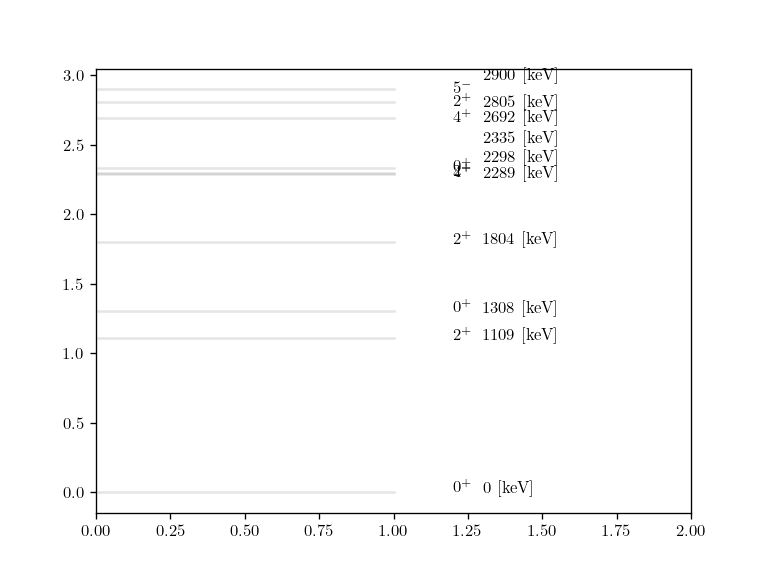

In [52]:
analyzer.plot_scheme()